In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/fairness_discrepancy")

In [3]:
import utils as ut
import loss_funcs as lf
import numpy as np
from prep_adult_data import *
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [4]:
with open('/content/drive/MyDrive/fairness_discrepancy/prep_adult_data.py', 'rb') as f:
  pass

In [ ]:
!python3 /content/drive/MyDrive/fairness_discrepancy/test_adult_data.py

Looking for file 'adult.data' in the current directory...
File found in current directory..
Looking for file 'adult.test' in the current directory...
File found in current directory..
Loading only 10000 examples from the data
Total data points: 10000
# non-protected examples: 6754
# protected examples: 3246
Non-protected in positive class: 2080 (31%)
Protected in positive class: 372 (11%)
P-rule is: 37%
iter:  10 , lambda:  1 , alpha:  0.5 , kernel: rbf method:  cobyla , catol:  0.1
c_init:  [6.22300636e-05 1.69693936e-05 6.47108542e-05 ... 1.37858120e-05
 6.16715669e-05 5.39234585e-05]
tcmalloc: large alloc 1176846336 bytes == 0x56520c9ce000 @  0x7fe0d589c1e7 0x7fe0d1c3046e 0x7fe0d1c80c7b 0x7fe0d1c81290 0x7fe0b81883cc 0x7fe0b8186ec6 0x5651ee4698e9 0x5651ee4ddade 0x5651ee4d7e0d 0x5651ee3a9e2b 0x5651ee4da1e6 0x5651ee4d7b0e 0x5651ee46a77a 0x5651ee4d986a 0x5651ee4d7b0e 0x5651ee46a77a 0x5651ee4dce50 0x5651ee4d7e0d 0x5651ee46a77a 0x5651ee4d8a45 0x5651ee4d7e0d 0x5651ee46a77a 0x5651ee4d8a45 0

In [5]:
""" Load the adult data """
X, y, x_control = load_adult_data() # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data



""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

loss_function = lf.discrepancy_loss
sensitive_attrs = ["sex"]

Looking for file 'adult.data' in the current directory...
File found in current directory..
Looking for file 'adult.test' in the current directory...
File found in current directory..
Total data points: 45222
# non-protected examples: 30527
# protected examples: 14695
Non-protected in positive class: 9539 (31%)
Protected in positive class: 1669 (11%)
P-rule is: 36%


In [ ]:
for j in range(10):
#     for i in range(x_train.shape[0]):
#         kernel_values.append(np.squeeze(ut.rbf_kernel(x_train[i], x_train)))
    n = x_train.shape[0]
    kernel_matrix = np.zeros((n, n))
    rbf_kernel = ut.rbf_kernel(1/n)
    for i in range(n):
        for j in range(n):
            kernel_matrix[i, j] = rbf_kernel(x_train[i], x_train[j])
#     kernel_values  = np.array(kernel_matrix)
    svm_loss = .5*np.dot((y_train*y_train).T @ kernel_matrix, y_train*y_train)
    svm_loss -= y_train.sum()
    print(svm_loss)

In [6]:
def train_test_classifier():
  final_c, Cs, losses, kernel_matrix = ut.train_model(x_train, y_train, x_control_train, loss_function, sensitive_attrs, \
                                                      max_iter, alpha, l, method, initiator, catol)
  y_train_predicted, y_test_predicted = ut.predict(final_c, x_train, y_train, x_test, kernel_matrix)
  train_score, test_score, correct_answers_train, correct_answers_test = \
          ut.check_accuracy(None, kernel_matrix, x_train, y_train, x_test, y_test, \
                    y_train_predicted, y_test_predicted)
  print("Train data:")
  print("------------")
  print("Train accuracy : ", train_score)
  p_rule_train = ut.compute_p_rule(x_control_train["sex"], y_train_predicted)
  print()
  print("Test data: ")
  print("------------")
  print("Test accuracy : ", test_score)
  p_rule_test = ut.compute_p_rule(x_control_test["sex"], y_test_predicted)
  print("------------------------------------------------------------------------")
  print("------------------------------------------------------------------------")
  return Cs, losses, train_score, test_score, p_rule_train, p_rule_test

In [7]:
method = 'cobyla'
# l_list = np.linspace(start= 0.00000001, stop= 10, num= 5)     # lamda list
# alpha_list = np.linspace(start=0.0 , stop= 1.0, num= 10)
# initiator_list = np.linspace(start= 0, stop= 0.01, num= 10) # for initial values of c
max_iter_list = np.linspace(start= 100, stop= 1000, num= 10) # no of iterations
# catol_list = np.linspace(start=0, stop= 0.01, num= 5)
initiator = 0.001
l = 1
catol = 0.001
alpha = 0.5
max_iter = 10

In [8]:
i = 0
result = {'l':[], 'alpha':[], 'initiator':[], 'max_iter':[], 'catol':[], 'c':[], 'loss':[],
                         'train_accuracy':[], 'test_accuracy':[], 'p_rule_train':[],
                             'p_rule_test':[]}

In [9]:
for max_iter in max_iter_list:
    print(i)
    with open('temp'+ str(i) +'.log', 'w') as f:
        with redirect_stdout(f):
            c, loss, train_accuracy, test_accuracy, p_rule_train,\
                                            p_rule_test = train_test_classifier()
            result['l'].append(l)
            result['alpha'].append(alpha)
            result['max_iter'].append(max_iter)
            result['initiator'].append(initiator)
            result['catol'].append(catol)
            result['c'].append(c)
            result['loss'].append(loss)
            result['train_accuracy'].append(train_accuracy)
            result['test_accuracy'].append(test_accuracy)
            result['p_rule_train'].append(p_rule_train)
            result['p_rule_test'].append(p_rule_test)
    i = i+1

0


ValueError: ignored

In [ ]:
print(result['train_accuracy'])
print(result['test_accuracy'])

In [ ]:
c, loss, train_accuracy, test_accuracy, p_rule_train,\
                                                p_rule_test = train_test_classifier()
print("train accuracy: ", train_accuracy)
print("test accuracy: ", test_accuracy)
# print("c : ", c)
print("final loss: ", loss)
print("p rule train : ", p_rule_train)
print("p rule test: ", p_rule_test)

iter:  3 , lambda:  1 , alpha:  0.5 , kernel: rbf method:  cobyla , catol:  0.0001
c_init:  [0.0006223  0.00016969 0.00064711 ... 0.00013786 0.00061672 0.00053923]
alpha:  0.5
c:  [0.0006223  0.00016969 0.00064711 ... 0.00013786 0.00061672 0.00053923]
loss:  1083.6357401589705
alpha:  0.5
c:  [1.00062230e+00 1.69693936e-04 6.47108542e-04 ... 1.37858120e-04
 6.16715669e-04 5.39234585e-04]
loss:  991.6775910837445
alpha:  0.5
c:  [1.00062230e+00 1.00016969e+00 6.47108542e-04 ... 1.37858120e-04
 6.16715669e-04 5.39234585e-04]
loss:  910.595840103921
weights:  [1.00062230e+00 1.00016969e+00 6.47108542e-04 ... 1.37858120e-04
 6.16715669e-04 5.39234585e-04]
cy dot constraint : -3.807713144045085
Optimization problem did not converge.. Check the solution returned by the optimizer.
Returned solution is:
     fun: 910.595840103921
   maxcv: 3.807813144045085
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 3
  status: 4
 su

ZeroDivisionError: ignored

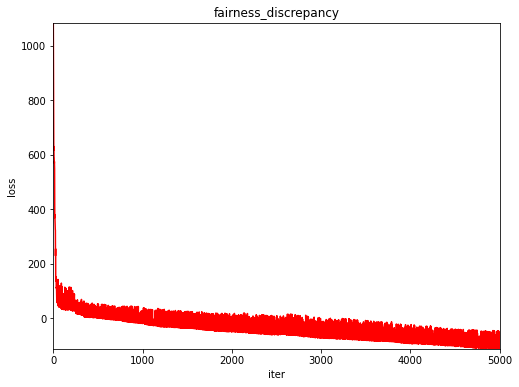

In [ ]:
plt.figure(figsize=(8,6))
plt.title('fairness_discrepancy')
plt.xlabel('iter')
plt.ylabel('loss')
plt.axis([0, max_iter, min(loss), max(loss)])
plt.plot([i for i in range(max_iter)], loss, 'r-')

In [ ]:
plt.savefig('test1.png', bbox_inches='tight', dpi=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
plt.title('simpleSVM')
plt.xlabel('data_size')
plt.ylabel('accuracy')
plt.plot(data_sizes.astype(int), train_accuracies, 'r-', data_sizes.astype(int), test_accuracies, 'b-')